# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction

The Zeeman slower is a device used to slow down a beam of atoms using the radiation pressure from a counter-propagating monochromatic laser beam, while compensating for the changing Doppler shift.
Therefore, the laser exerts a force on the atoms, slowing them down over a certain distance with a force, $F_{scatt} = \sigma_{abs} I/c = \hbar k R_{scatt}$, where $\sigma_{abs}$ is the absorption cross-section, $I$ is the laser intensity, $c$ is the speed of light, $\hbar$ is the reduced Planck constant, $k$ is the wavevector of the laser light, and $R_{scatt}$ is the scattering rate $$R_{scatt} = \frac{\Gamma}{2} \frac{\Omega^2/2}{\delta^2+\Omega^2/2+\Gamma^2/4}$$ where $\Gamma$ is the linewidth, $\Omega$ is the Rabi frequency, and $\delta (z) = \omega_L - \omega_0 +kv(z)$ is the detuning where $\omega$ is the laser frequency, $\omega_0$ is the atomic transition frequency, and $kv(z)$ is the Doppler shift.
We can also define the laser detuning at rest as $\delta_0 = \omega_L - \omega_0$ such that the detuning becomes $\delta (z) = \delta_0 +kv(z)$.

Defining the saturation parameter as $s = I/I_{sat} = 2 \Omega^2/\Gamma^2$, where $I_{sat}$ is the saturation intensity, we can rewrite the scattering force as:$$F_{scatt} = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+4(\delta/\Gamma)^2}.$$

When the intensity tends to infinity ($s \gg 1$) and the detuning is zero ($\delta = 0$), the scattering rate reaches its maximum value of $R_{scatt,max} = \Gamma/2$, leading to a maximum deceleration of the atoms given by:
$$a_{max} = \frac{F_{scatt,max}}{m} = \frac{\hbar k}{m} \frac{\Gamma}{2} = \frac{v_r}{2\tau}$$
where $m$ is the mass of the atom, $v_r = \hbar k / m$ is the recoil velocity, and $\tau$ is the excited state lifetime.

### Species properties and constants
Here we define relevant properties (mass, wavelength and linewidth) of several common atomic species used for laser cooling.
Such that we can use their linewidth to study in first instance the range where the scattering rate is significant for different saturation parameters.
We also define some useful constants and import necessary libraries.

In [22]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck's constant)
hbar = hh / (2.0 * math.pi)
mu_B = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)

# Species dropdown with mass, wavelength (m), gamma (rad/s), and saturation intensity (mW/cm^2)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2 * math.pi * 34.6e6, 'sat_intensity': 60.0},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2 * math.pi * 32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2 * math.pi * 6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2 * math.pi * 5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2 * math.pi * 9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2 * math.pi * 29.0e6},
}

# Dropdown = an interactive ipywidgets selection control that lets the user pick
# exactly one option from a list. Its current selection is available as `species.value`
# and is used in later cells to look up `species_data[species.value]` and refresh plots.
# Changing this widget will trigger observers (attached later in the notebook) to
# recompute figures and labels for the chosen atom.
species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
)

# If the interactive widgets already exist, refresh them so display labels
# pick up any newly edited parameter values (e.g., gamma).
for refresh_func_name in ("refresh_simple", "refresh_advanced"):
    refresh_callable = globals().get(refresh_func_name)
    if callable(refresh_callable):
        try:
            refresh_callable()
        except Exception as exc:
            print(f"Warning: {refresh_func_name} failed to refresh ({exc})")

### Scattering rate

Here we define a function that calculates the scattering rate, $R_{scatt}$, as a function of detuning, $\delta$, and saturation parameter, $s$, to study its dependence around zero detuning within the range of Ca linewidth approximately (as an order of magnitude).
It shows that for a given detuning, increasing the saturation parameter increases the scattering rate until a limit of $\Gamma / 2$; the larger the detuning, the more $s$ it takes to reach the limit of the scattering rate.
For a given saturation parameter, the scattering rate peaks at zero detuning and it is symmetric for positive and negative detuning; the larger saturation parameter, the broader and peak closer to $\Gamma / 2$.

In [23]:
# Visualize how the scattering rate depends on saturation parameter and detuning
def scattering_rate(s_param, delta, gamma):
    return 0.5 * gamma * (s_param / (1.0 + s_param + 4.0 * (delta / gamma) ** 2))
# Get current species parameters
current_species = species_data[species.value]
gamma_val = current_species["gamma"]
# Prepare data for plotting
s_values = np.logspace(-2, 3, 400)
detuning_values = np.linspace(-4 * gamma_val, 4 * gamma_val, 600)
# Sample values for plotting
detuning_samples = [0.0, 0.5 * gamma_val, 1.0 * gamma_val, 2.0 * gamma_val]
saturation_samples = [0.05, 0.2, 1.0, 5.0, 20.0, 100.0]

# Widgets for eta target and report label
target_eta_slider = w.FloatSlider(
    description="η target",
    value=0.75,
    min=0.4,
    max=0.95,
    step=0.01,
    readout_format=".2f",
    continuous_update=False,
)
eta_report_label = w.HTML(value="")

def render_scattering_plots(target_eta):
    rates_vs_s = {delta: scattering_rate(s_values, delta, gamma_val) for delta in detuning_samples}
    rates_vs_delta = {s: scattering_rate(s, detuning_values, gamma_val) for s in saturation_samples}

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))
    # Left plot: eta vs s for different detunings
    thresholds = []
    # Calculate saturation parameter thresholds for target eta at each detuning
    threshold_map = {}
    for delta, rates in rates_vs_s.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"$\\delta$ = 2$\\pi$ {delta / (2 * math.pi * 1e6):.1f} MHz"
        ax_left.plot(s_values, eta_norm, label=label)
        mask = eta_norm >= target_eta
        if np.any(mask):
            idx = np.argmax(mask)
            if idx == 0:
                s_thresh = s_values[0]
            else:
                y0, y1 = eta_norm[idx - 1], eta_norm[idx]
                x0, x1 = s_values[idx - 1], s_values[idx]
                if y1 != y0:
                    s_thresh = np.interp(target_eta, [y0, y1], [x0, x1])
                else:
                    s_thresh = x1
            thresholds.append(s_thresh)
            threshold_map[delta] = s_thresh
            ax_left.scatter(s_thresh, target_eta, color="black", s=25, zorder=15)
        else:
            thresholds.append(np.nan)
            threshold_map[delta] = float("nan")

    # Plot target eta line and shaded region
    ax_left.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2, label=f"$\\eta$ = {target_eta:.2f}")
    s_delta0 = threshold_map.get(0.0, float("nan"))
    # Plot vertical line and shaded region if threshold exists at delta = 0
    if math.isfinite(s_delta0):
        ax_left.axvline(s_delta0, color="tab:red", linestyle=":", linewidth=1.2)
        x_shade = np.logspace(np.log10(s_delta0), np.log10(s_values[-1]), 200)
        ax_left.fill_between(
            x_shade,
            target_eta,
            1.0,
            facecolor="tab:red",
            alpha=0.08,
            label="s meeting $\\eta$ ≥ target",
        )
    ax_left.set_xscale("log")
    ax_left.set_xlabel("Saturation parameter s")
    ax_left.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_left.set_xlim(1e-2, 1e3)
    ax_left.set_ylim(0.0, 1.05)
    ax_left.legend(loc="lower right", fontsize=8)
    ax_left.grid(True, which="both", ls=":", alpha=0.5)

    # Right plot: eta vs detuning for different saturation parameters
    for s_val, rates in rates_vs_delta.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"s = {s_val:.2f}" if s_val < 10 else f"s = {s_val:.0f}"
        ax_right.plot(detuning_values / (2 * math.pi * 1e6), eta_norm, label=label)

    ax_right.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2)
    ax_right.axhspan(
        target_eta,
        1.0,
        facecolor="tab:red",
        alpha=0.08,
        label="$\\eta$ ≥ target",
    )
    ax_right.set_ylim(0.0, 1.05)
    ax_right.set_xlabel("Detuning $\\delta$ / (2$\\pi$·MHz)")
    ax_right.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_right.legend(loc="upper right", fontsize=8)
    ax_right.grid(True, ls=":", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Update report label
    if math.isfinite(s_delta0):
        eta_report_label.value = (
            f"<b>s at δ = 0 meeting η = {target_eta:.2f}:</b> {s_delta0:.3f}"
        )
    else:
        eta_report_label.value = (
            f"<span style='color:red'><b>No s in plotted range reaches η = {target_eta:.2f} at δ = 0.</b></span>"
        )

plot_output = w.interactive_output(
    render_scattering_plots, {"target_eta": target_eta_slider}
)

display(w.VBox([target_eta_slider, eta_report_label]), plot_output)

Output()

*Note for the left-side plot*: What we are plotting here is the scattering rate normalized to the maximum scattering rate, i.e., $R_{scatt} / R_{scatt,max}$ which we can define as a quantity $\eta$.
This is of great relevance for the Zeeman slower as setting the eta we will work, sets the deceleration we will apply to the atoms.
Therefore, the **length of the Zeeman slower** and the magnetic field profile will depend on the chosen eta, and the **minimum $s$ such that the ZS will work**.

So, the shorter the Zeeman slower we want, the higher the eta we need, and therefore the higher the saturation parameter we will need to achieve that eta at the maximum detuning (i.e., at the maximum velocity we want to slow down).

The detuning that we apply on the laser from the ideal one at rest, $\delta_0$, will also affect the effective eta we will have at different points of the Zeeman slower, as the detuning will not be zero at all points.
Plus, this range might not be in the MHz range but in the GHz range for fast atomic beams, so the detuning effect will be more significant. 

### Velocity and magnetic field profiles

Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0 = v(z=0)$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which is usually expressed $a=\eta a_{max}$ where $\eta \in [0,1]$ is typically between 0.5 and 0.8 to give some margin compared to the maximum deceleration.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f = v(z=L)$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$$
such that we can express the velocity profile:
$$v(z) = \sqrt{v_0^2 - \left(v_0^2 - v_f^2\right)\frac{z}{L}}$$

Assuming $v_f=0$, $L = \frac{v_0^2}{2 \eta a_{max}}$ and $v(z) = v_0 \sqrt{1 - \frac{z}{L}}$.

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_L (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu_B$ is the Bohr magneton while $\mu = g_{eff} \mu_B$ where $g_{eff}$ is the effective Landé g-factor, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process until $v_f = 0$ via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is for a general final velocity $v_f$,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{v_0^2 - v_f^2}{v_0^2}\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= - \hbar \delta_0$.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## Increasing-field Zeeman slower study

The following code aims to study the increasing-field Zeeman slower for a general final velocity $v_f$.
The key parameters that can be adjusted are the initial velocity $v_0$, final velocity $v_f$, and slowing efficiency $\eta$, which will mainly determine the length of the Zeeman slower, $L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$, together with the atom species to be slowed, which has a certain mass $m$, linewidth $\gamma$, and wavelength $\lambda$ that set the $a_{max} = \frac{h}{m \lambda} \frac{\Gamma}{2}$; and the magnetic field profile, $B_-(z)$, which is also affected by the effective Landé g-factor $g_{eff}$ of the transition and the bias magnetic field, $B_{bias}$, which will also affect the laser detuning needed, $\delta_0$.

The distance from the oven to the Zeeman slower is fixed due to experimental constraints, which is 156 mm, the tube where the Zeeman slower is mounted is 300 mm, and the distance between the end of this tube and the deflectometer is 53 mm, which is the last position where the laser overlaps the atomic beam.

In [24]:
# Clean up previous UI instances to prevent stacked displays when this cell is re-run
for _widget_name in ("_advanced_ui", "_advanced_output"):
    # Widgets stick around across executions; closing avoids duplicated plots/controls.
    _existing_widget = globals().get(_widget_name)
    if _existing_widget is not None:
        try:
            _existing_widget.close()
        except Exception:
            pass

def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """
    Plot Zeeman-slower magnetic field and velocity versus position.

    Parameters
    - z_plt (array-like): Positions along the slower [m]. Must be the same length as v_plt and B_plt.
    - v_plt (array-like): Velocity profile v(z) [m/s].
    - B_plt (array-like): Magnetic-field profile B(z) [T]. Converted to Gauss (×1e4) for display.
    - L_plt (float): Slower length [m]. Used for the plot title only.

    Behavior
    - Produces a matplotlib figure with two y-axes sharing z:
      left axis: B(z) in Gauss; right axis: v(z) in m/s.
    - Uses NaN-safe maxima to set y-limits and adds a small negative margin.
    - Applies grid and tight layout, then displays the figure. Returns None.

    Notes
    - NaN values are ignored for axis scaling.
    - If arrays are empty, minimal nonzero limits are used to avoid errors.
    - Inputs are not modified.
    """
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color="tab:blue")
    ax1.plot(z_plt, B_plt * 1e4, color="tab:blue", lw=2, label="B(z) [G]")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, ls="--", alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color="tab:orange")
    ax2.plot(z_plt, v_plt, color="tab:orange", lw=2, label="v(z) [m/s]")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    max_B = np.nanmax(B_plt * 1e4) if np.size(B_plt) else 1.0
    max_v = np.nanmax(v_plt) if np.size(v_plt) else 1.0
    max_B = max(1e-8, max_B) * 1.05
    max_v = max(1e-8, max_v) * 1.05
    ax1.set_ylim(-0.05 * max_B, max_B)
    ax2.set_ylim(-0.05 * max_v, max_v)
    ax1.set_title(f"Zeeman slower profile (L = {L_plt*100:.2f} cm)")
    plt.tight_layout()
    plt.show()

def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, B_bias=250, eta=0.5, n_points=500):
    """
    Compute the 1D Zeeman-slower magnetic-field and velocity profiles for an
    increasing-field design assuming constant deceleration a = eta * a_max,
    where a_max = (ħ k γ / 2) / m.

    Parameters
    - mass_amu (float): Atomic mass in atomic mass units [amu].
    - wavelength (float): Transition wavelength [m].
    - gamma (float): Natural linewidth Γ, angular frequency [rad/s].
    - g_eff (float): Effective magnetic g-factor (dimensionless).
    - v0 (float): Entrance velocity (capture velocity) [m/s].
    - vf (float): Exit velocity (final velocity) [m/s].
    - B_bias (float): Entrance bias field in Gauss.
    - eta (float): Fraction of the maximum scattering force (0 < eta ≤ 1).
    - n_points (int): Number of samples along z inside the slower.

    Returns
    - z (ndarray): Positions along the slower [m], from 0 to L.
    - v (ndarray): Velocity profile v(z) [m/s].
    - B (ndarray): Magnetic-field profile B(z) [T].
    - L (float): Slower length [m].
    - diagnostics (dict): Additional scalars:
        * F_max [N]     : Maximum scattering force (s → ∞).
        * a_max [m/s^2] : Maximum deceleration = F_max / m.
        * a [m/s^2]     : Chosen deceleration = eta * a_max.
        * B_delta [T]   : Scale field = ħ k v0 / (μ_B g_eff).
        * delta_ideal   : Design detuning (angular) for z=0 resonance [rad/s].

    Notes
    - B_bias is provided in Gauss; the returned B(z) is in Tesla (multiply by 1e4 to get Gauss).
    - Raises ValueError if the computed deceleration is non-positive or if v0 ≤ vf.
    - Uses the standard increasing-field Zeeman-slower profile:
        v(z) = sqrt(v0^2 - (v0^2 - vf^2) * z / L)
        B(z) = B_bias_T + B_delta * (1 - sqrt(1 - ((v0^2 - vf^2)/v0^2) * (z / L)))
      with L = (v0^2 - vf^2) / (2 a) and B_delta = ħ k v0 / (μ_B g_eff).
    """
    mm = mass_amu * amu     # Convert mass from amu to kg
    kk = 2 * math.pi / wavelength   # Wave number k [1/m]
    F_max = hbar * kk * gamma / 2.0  # Max scattering force [N]
    a_max = F_max / mm      # Max deceleration [m/s^2]
    aa = eta * a_max        # Chosen deceleration [m/s^2]
    # Input validation
    if aa <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    # Ideal-length and magnetic profile for the increasing-field design.
    LL = (v0 * v0 - vf * vf) / (2.0 * aa)       # Slower length [m]
    B_delta = hbar * kk / (mu_B * g_eff) * v0     # Scale field [T]
    B_bias_T = B_bias * 1e-4                    # Gauss slider uses CGS units → Tesla
    zz = np.linspace(0.0, LL, n_points)          # Positions along the slower [m]
    vv = np.sqrt(v0**2 - (v0**2 - vf**2) * zz / LL)   # Velocity profile [m/s]
    # Magnetic field profile [T]
    BB = B_bias_T + B_delta * (1 - np.sqrt(1 - ((v0**2 - vf**2) / v0**2) * (zz / LL)))
    delta_ideal = - mu_B * g_eff * (B_bias_T + B_delta) / hbar    # Design detuning [rad/s]
    diagnostics = {
        "F_max": F_max,     # Maximum scattering force [N]
        "a_max": a_max,     # Maximum deceleration [m/s^2]
        "a": aa,            # Chosen deceleration [m/s^2]
        "B_delta": B_delta,  # Scale field [T]
        "delta_ideal": delta_ideal,  # Design detuning [rad/s]
    }
    return zz, vv, BB, LL, diagnostics

# Slider definitions (all use continuous_update=False to avoid overwhelming plots).
v0_adv = w.FloatSlider(description="v0 (m/s)", value=1000.0,
                       min=400.0, max=1200.0, step=5.0, continuous_update=False)
vf_adv = w.FloatSlider(description="vf (m/s)", value=50.0,
                       min=0.0, max=100.0, step=5.0, continuous_update=False)
eta_adv = w.FloatSlider(description="eta", value=0.75,
                        min=0.01, max=1.0, step=0.01, continuous_update=False)
B_bias_adv = w.FloatSlider(description="B_bias (G)", value=250.0,
                           min=1.0, max=500.0, step=1.0, continuous_update=False)
g_eff_adv = w.FloatSlider(description="g_eff", value=1.0,
                          min=0, max=2.0, step=0.01, continuous_update=False)
points_adv = w.IntSlider(description="points", value=600,
                         min=50, max=1000, step=50, continuous_update=False)
# Dynamic labels and output container.
wavelength_label_advanced = w.HTML()
gamma_label_advanced = w.HTML()
summary_label_advanced = w.HTML()
out_advanced = w.Output()
# Update wavelength and gamma labels based on selected species.
def update_info_advanced():
    d = species_data[species.value]
    wavelength_label_advanced.value = f"<b>&lambda;</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_advanced.value = f"<b>&Gamma;/2&pi;</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"
# Refresh function to recompute and plot the profiles.
def refresh_advanced(change=None):
    d = species_data[species.value]
    update_info_advanced()
    try:
        zz, vv, BB, LL, diag = compute_B_z_forces(
            mass_amu=d['mass'],
            wavelength=d['wavelength'],
            gamma=d['gamma'],  # Use angular frequency
            v0=v0_adv.value,
            vf=vf_adv.value,
            eta=eta_adv.value,
            B_bias=B_bias_adv.value,
            g_eff=g_eff_adv.value,
            n_points=points_adv.value,
        )
    except Exception as exc:
        summary_label_advanced.value = f"<span style='color:red'>Parameter error: {exc}</span>"
        with out_advanced:
            clear_output(wait=True)
            print("Parameter error:", exc)
        return

    # Extend the profile with zero-field, constant-velocity regions before and after the slower.
    L_max = 300e-3          # 30 cm maximum slower length
    pre_length = 156e-3 + (L_max - LL) # fixed 15.6 cm input beam path from oven + remaining length up to L_max
    post_length = 53e-3     # fixed 5.3 cm output beam path + 252e-3 until MOT
    # Estimate density of points to maintain resolution in extended regions.
    base_span = max(zz[-1] - zz[0], 1e-3)
    density = max(points_adv.value - 1, 1) / base_span
    pre_points = max(200, int(math.ceil(pre_length * density)))
    post_points = max(100, int(math.ceil(post_length * density)))
    z_pre = np.linspace(zz[0] - pre_length, zz[0], pre_points + 1)[:-1]
    z_post = np.linspace(zz[-1], zz[-1] + post_length, post_points + 1)[1:]
    # Constant velocity and zero magnetic field in the extended regions.
    B_pre = np.zeros_like(z_pre)
    B_post = np.zeros_like(z_post)
    v_pre = np.full_like(z_pre, vv[0])
    v_post = np.full_like(z_post, vv[-1])
    z_extended = np.concatenate([z_pre, zz, z_post]) if z_pre.size or z_post.size else zz
    B_extended = np.concatenate([B_pre, BB, B_post]) if z_pre.size or z_post.size else BB
    v_extended = np.concatenate([v_pre, vv, v_post]) if z_pre.size or z_post.size else vv

    # Plot within the output widget.
    with out_advanced:
        clear_output(wait=True)
        plot_profile(z_extended, v_extended, B_extended, LL)
    summary_label_advanced.value = (
        f"<b>Slower length</b>: {LL*100:.2f} cm"
        f"<br><b>Max force</b>: {diag['F_max']:.3e} N"
        f"<br><b>Design detuning</b>: {diag['delta_ideal']/(2 * math.pi * 1e9):.2f} &times; 2&pi; GHz"
        f"<br><b>B0</b>: {diag['B_delta']*1e4:.1f} G"
    )
    # Persist the latest profile + metadata so later cells (phase-space) can reuse it.
    globals()["_advanced_state"] = {
        "species": species.value,
        "species_props": dict(d),
        "z": zz,
        "v": vv,
        "B": BB,
        "z_extended": z_extended,
        "v_extended": v_extended,
        "B_extended": B_extended,
        "slower_bounds": (float(zz[0]), float(zz[-1])),
        "L": LL,
        "diagnostics": diag,
        "params": {
            "v0": v0_adv.value,
            "vf": vf_adv.value,
            "eta": eta_adv.value,
            "B_bias": B_bias_adv.value,
            "g_eff": g_eff_adv.value,
            "points": points_adv.value,
        }
    }

# Attach observers to refresh on widget value changes.
_advanced_observers = globals().get("_advanced_observers", [])
for widget, handler in _advanced_observers:
    try:
        widget.unobserve(handler, names='value')
    except Exception:
        pass
_advanced_observers = []
# Attach new observers.
advanced_widgets = (species, v0_adv, vf_adv, eta_adv, B_bias_adv, g_eff_adv, points_adv)
for widget in advanced_widgets:
    widget.observe(refresh_advanced, names='value')
    _advanced_observers.append((widget, refresh_advanced))
# Store observers globally to allow cleanup on re-execution.
ui_advanced = w.VBox([
    w.HBox([species, wavelength_label_advanced, gamma_label_advanced]),
    w.HBox([v0_adv, vf_adv, eta_adv]),
    w.HBox([B_bias_adv, g_eff_adv, points_adv]),
    summary_label_advanced,
])

globals()["_advanced_ui"] = ui_advanced
globals()["_advanced_output"] = out_advanced

refresh_advanced()
display(ui_advanced, out_advanced)

Output()

## Scattering force map and phase-space trajectories

The motion of the atoms in the Zeeman slower can be described by the 1D Newtonian model
$$m \frac{d^2z}{dt^2} = F_{scatt}(z,v) = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+\frac{4 \delta(z,v)^2}{\Gamma^2}}$$
where the scattering force $F_{scatt}(z,v)$ depends on both position and velocity through the detuning $\delta(z,v) = \delta_0 + k v + \mu B(z)/\hbar$ for the increasing field configuration (the decreasing field configuration is analogous with a sign change in the magnetic field term).

The key parameters that can be adjusted are:
- $\delta_0$ shifts the force field map in the velocity axis, up when decreased (so, capture velocity and final velocity increase), and viceversa.
- $s$ increasing it: decreases the actual final velocity, and increases the capture velocity, i.e., the maximum initial velocity that can be slowed down.

In [25]:
# PARAMS AND GUI SETUP
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run previous cell (advanced Zeeman slower widget)" \
    "before executing this cell so the magnetic profile is available.")
# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)
# Pull the stored species values so this cell mirrors the widget configuration.
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec["sat_intensity"] if "sat_intensity" in spec else 60.0
kk = 2 * math.pi / wavelength
# Extract parameters from stored state.
params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf." \
    "Rerun cell (adv ZS widget) with valid parameters.")
z_axis_core = np.asarray(advanced_state["z"])
B_profile_core = np.asarray(advanced_state["B"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
L_design = float(advanced_state["L"])
slower_bounds = advanced_state["slower_bounds"]
z_slower_start, z_slower_end = slower_bounds
diag = advanced_state["diagnostics"]
delta_design = float(diag["delta_ideal"])
eta_design = float(params["eta"])
F_max = float(diag["F_max"])
a_max = float(diag["a_max"])
ideal_detuning = float(diag["delta_ideal"])

# Slider controls to explore different scattering intensities and laser detunings around the ideal design.
intensity_slider = w.FloatSlider(description="I (mW/cm²)", value=600.0,
                                 min=10.0, max=2000.0, step=10.0, continuous_update=False)
span_ghz = max(0.5, abs(ideal_detuning / (2 * math.pi * 1e9)) * 0.5)
# Detuning slider (Δ/2π in GHz) centered on the design detuning, with an explanatory tooltip.
detuning_center_ghz = ideal_detuning / (2 * math.pi * 1e9)
detuning_slider = w.FloatSlider(
    description="Δ/2π (GHz)",
    value=detuning_center_ghz,
    min=detuning_center_ghz - span_ghz / 2.0,
    max=detuning_center_ghz + span_ghz / 2.0,
    step=0.005,
    continuous_update=False,
    readout_format=".3f",
)
detuning_slider.tooltip = (
    "Laser detuning from the atomic resonance divided by 2π, expressed in GHz. "
    "Negative values are red-detuned. Range is centered on the design detuning."
)
traj_count_slider = w.IntSlider(description="Traj count", value=12,
                                min=4, max=40, step=1, continuous_update=False)
max_v0_slider = w.FloatSlider(
    description="Max v0 (m/s)",
    value=v_capture * 1.2,
    min=max(1.0, v_final * 0.9),
    max=v_capture * 1.7,
    step=10.0,
    continuous_update=False,
 )
# Info labels
ideal_detuning_label = w.HTML(
    f"<b>Ideal detuning/2&pi;</b>: {detuning_center_ghz:.3f} GHz"
 )
sat_info_label = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in:.2f} (I/I_sat)"
 )
eta_reference_label = w.HTML("<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;</b>: n/a")

# -------------------- FORCE MAP and TRAJECTORIES SIMULATION --------------------
# Sample velocities well below zero so the force map shows deceleration all the way through the stop.
v_min = -0.25 * v_capture
v_max = max_v0_slider.value * 1.05
vel_axis = np.linspace(v_min, v_max, 500)
gray_cmap = ListedColormap(plt.cm.Greys(np.linspace(0.0, 0.85, 256)))

# Precompute quantities for trajectory integration.
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = L_design / v_capture
# flight time for the design velocity profile through the slower as an integration of v(z)=dz/dt:
def _inv_velocity(z_rel: float) -> float:
    v_sq = v_capture**2 - (v_capture**2 - v_final**2) * z_rel / L_design
    return 1.0 / math.sqrt(max(v_sq, 1e-12))
flight_time_ideal, _ = integrate.quad(_inv_velocity, 0.0, L_design, limit=200)
# Sanity check on flight time.
if flight_time < 1e-6:
    raise RuntimeError("Unrealistically short flight time through the slower; check v0 and slower length.")
print("Estimated flight time through the slower ct capture vel {:.3f} ms".format(flight_time * 1e3))
print("Estimated flight time (cap vel ideal profile) {:.3f} ms".format(flight_time_ideal * 1e3))
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # m/s to avoid stalling

# Interpolate the magnetic field profile onto a finer z grid for force map rendering.
z_force = np.linspace(z_min, z_max, max(len(z_profile), 800))
B_force = np.interp(z_force, z_profile, B_profile_extended)

# Identify field-free drift regions before and after the slower for plotting visualization.
drift_regions = []
if z_min < z_slower_start:
    drift_regions.append((z_min, z_slower_start))
if z_max > z_slower_end:
    drift_regions.append((z_slower_end, z_max))

def scattering_force_and_eta(delta_laser, B_T, velocities, s_value):
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    force = hbar * kk * gamma / 2.0 * (s_value / denom)
    return force, s_value / denom

def integrate_trajectory(v_init, delta_laser, s_value, record_eta=False):
    '''Integrate a single trajectory starting from z_min with initial velocity v_init'''
    # Adjust max steps based on initial speed to ensure adequate resolution
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    # Initialize trajectory lists
    traj_z = [z_min]
    traj_v = [v_init]
    eta_samples = [] if record_eta else None
    # Time-stepping loop
    for _ in range(max_steps):
        # Get current position and velocity
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        # Prevent stalling at very low speeds
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else 1.0
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        # Sample magnetic field and compute force
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # Update velocity and position using Euler integration
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        if record_eta:
            eta_samples.append(eta_point)

        # Termination conditions: exit if outside z bounds and moving away
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    if record_eta:
        return np.asarray(traj_z), np.asarray(traj_v), np.asarray(eta_samples)
    return np.asarray(traj_z), np.asarray(traj_v)


def plot_phase_space(intensity_mw_cm2, detuning_ghz, trajectory_count, max_initial_velocity):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0  # Saturation parameter
    delta_laser = detuning_ghz * 1e9 * 2.0 * math.pi       # Convert GHz to rad/s
    # Compute and update saturation info label.
    eta_ideal_slider = params["eta"]  # Ideal eta from the stored profile
    sat_info_label.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
        f"<br><b>&eta;<sub>imposed</sub></b>(&delta;=0) = {eta_ideal_slider:.3f}"
    )

    # Generate initial velocities for trajectory integration.
    traj_count = max(2, int(trajectory_count))
    upper_v0 = float(max_initial_velocity)
    upper_v0 = np.clip(upper_v0, v_final * 0.9 + 1e-6, max_v0_slider.max)
    lower_v0 = max(v_final * 0.9, 1.0)
    if upper_v0 <= lower_v0:
        raise ValueError(
            f"max_initial_velocity ({upper_v0:.3f} m/s) must be > lower bound ({lower_v0:.3f} m/s). "
            "Increase the 'Max v0 (m/s)' slider."
        )
    initial_velocities = np.linspace(lower_v0, upper_v0, traj_count)

    # Compute the scattering force map over position and velocity.
    force_grid = np.zeros((len(z_force), len(vel_axis)))
    for i, B_val in enumerate(B_force):
        force_grid[i] = scattering_force_and_eta(delta_laser, B_val, vel_axis, s0_val)[0]

    # Plot the force map and overlay trajectories.
    fig, ax = plt.subplots(figsize=(8.7, 4.3))
    im = ax.imshow(
        force_grid.T,
        extent=[z_force[0], z_force[-1], vel_axis[0], vel_axis[-1]],
        origin="lower",
        aspect="auto",
        cmap=gray_cmap,
        zorder=0,
    )
    # Shade the field-free drift regions with minimal opacity so the force map remains visible underneath.
    for idx, (z_lo, z_hi) in enumerate(drift_regions):
        ax.axvspan(
            z_lo,
            z_hi,
            facecolor="tab:blue",
            alpha=0.05,
            zorder=10,
            label="Field-free drift" if idx == 0 else None,
        )
    ax.axvline(z_slower_end, color="red", linestyle="--", linewidth=1, label="Slower end", zorder=10)
    ax.axvline(z_slower_start, color="red", linestyle="--", linewidth=1, zorder=10)

    # Integrate and plot the capture trajectory starting from v_capture
    capture_z, capture_v, capture_eta = integrate_trajectory(v_capture, delta_laser, s0_val, record_eta=True)
    capture_eta_z = capture_z[1 : capture_eta.size + 1] if capture_eta.size else np.asarray([])
    zs_mask = (capture_eta_z >= z_slower_start) & (capture_eta_z <= z_slower_end) if capture_eta.size else np.asarray([])
    capture_eta_slower_mean = (
        float(np.mean(capture_eta[zs_mask]))
        if capture_eta.size and np.any(zs_mask)
        else float("nan")
    )
    ax.plot(capture_z, capture_v, color="dimgray", linewidth=2.2, linestyle="--", label="Capture traj")

    # Integrate and plot trajectories for the range of initial velocities.
    trajectory_store = []
    final_velocity_records = []
    for v_init in initial_velocities:
        traj_z, traj_v = integrate_trajectory(v_init, delta_laser, s0_val)
        if traj_z.size < 2:
            continue
        trajectory_store.append((traj_z, traj_v, v_init))
        final_velocity_records.append((v_init, float(traj_v[-1])))

    for traj_z, traj_v, v_init in trajectory_store:
        ax.plot(traj_z, traj_v, label=f"v0={v_init:.0f} m/s", linewidth=1.2, zorder=10)

    ax.set_xlabel("z (m)")
    ax.set_ylabel("v (m/s)")
    ax.set_title(f"Phase space with stored profile ({species_name}, L={L_design*100:.2f} cm)")
    ax.set_axisbelow(False)
    ax.minorticks_on()
    ax.grid(True, which="both", color="black", linestyle=":", linewidth=0.45, alpha=0.7)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Scattering force (N)")
    plt.tight_layout()
    plt.show()

    # Plot eta profile along the capture trajectory for additional diagnostics.
    if capture_eta.size:
        fig_eta, ax_eta = plt.subplots(figsize=(8.7, 2.8))
        ax_eta.plot(capture_eta_z, capture_eta, color="tab:green", lw=1.8, label="η_eff (capture)")
        ax_eta.axhline(eta_ideal_slider, color="tab:red", ls="--", lw=1.2, label="η ideal")
        if math.isfinite(capture_eta_slower_mean):
            ax_eta.axhline(
                capture_eta_slower_mean,
                color="tab:purple",
                ls=":",
                lw=1.2,
                label="⟨η_eff⟩ within ZS",
            )
        ax_eta.axvspan(
            z_slower_start,
            z_slower_end,
            facecolor="tab:blue",
            alpha=0.06,
            label="Zeeman slower",
        )
        ax_eta.set_xlabel("z (m)")
        ax_eta.set_ylabel("η_eff")
        ax_eta.set_ylim(0.0, 1.05)
        ax_eta.grid(True, ls=":", alpha=0.5)
        ax_eta.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8, borderaxespad=0.6)
        ax_eta.set_title("Capture trajectory η_eff profile")
        plt.tight_layout()
        plt.show()

    # Update eta reference label
    if math.isfinite(capture_eta_slower_mean):
        eta_reference_label.value = (
            f"<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: {capture_eta_slower_mean:.3f}"
            f" (target {eta_ideal_slider:.3f})"
        )
    elif capture_eta.size:
        eta_reference_label.value = (
            "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a within slower span"
        )
    else:
        eta_reference_label.value = "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a"

    if final_velocity_records:
        final_initials = np.array([rec[0] for rec in final_velocity_records])
        final_speeds = np.array([rec[1] for rec in final_velocity_records])

        fig_final, ax_final = plt.subplots(figsize=(7, 3.8))
        ax_final.plot(final_initials, final_speeds, marker="o", lw=1.3, label="Final velocity")
        ax_final.axhline(0.0, color="gray", ls="--", lw=1, label="0 m/s")
        ax_final.set_xlabel("Initial velocity (m/s)")
        ax_final.set_ylabel("Final velocity (m/s)")
        ax_final.set_title("Final velocities after ZS + drift")
        ax_final.grid(True, ls=":", alpha=0.5)
        ax_final.set_yscale("symlog", linthresh=1.0, linscale=1.0, base=10)
        plt.tight_layout()
        plt.show()

        stats_html = (
            f"<b>Trajectories</b>: {final_initials.size}"
            f" | <b>Min final v</b>: {final_speeds.min():.2f} m/s"
            f" | <b>Max final v</b>: {final_speeds.max():.2f} m/s"
            f" | <b>Median final v</b>: {np.median(final_speeds):.2f} m/s"
        )
        display(w.HTML(f"<div style='margin-bottom:0.6em'>{stats_html}</div>"))

        cache_payload = {
            "initial_velocities": final_initials,
            "final_velocities": final_speeds,
            "intensity_mw_cm2": float(intensity_mw_cm2),
            "detuning_ghz": float(detuning_ghz),
            "trajectory_count": traj_count,
            "max_initial_velocity": upper_v0,
            "s_value": float(s0_val),
            "species": species_name,
            "z_bounds": (z_min, z_max),
            "slower_bounds": (z_slower_start, z_slower_end),
            "v_capture": v_capture,
            "v_final": v_final,
        }
        globals()["_phase_space_cache"] = cache_payload
        listeners = globals().get("_final_velocity_listeners", [])
        for listener in list(listeners):
            try:
                listener(cache_payload)
            except Exception as exc:
                print(f"Warning: final-velocity listener failed ({exc})")

controls = w.VBox([
    w.HBox([intensity_slider, detuning_slider]),
    w.HBox([traj_count_slider, max_v0_slider]),
    ideal_detuning_label,
    sat_info_label,
    eta_reference_label,
])
phase_output = w.interactive_output(
    plot_phase_space,
    {
        "intensity_mw_cm2": intensity_slider,
        "detuning_ghz": detuning_slider,
        "trajectory_count": traj_count_slider,
        "max_initial_velocity": max_v0_slider,
    },
 )

display(controls, phase_output)

Estimated flight time through the slower ct capture vel 0.260 ms
Estimated flight time (cap vel ideal profile) 0.495 ms


Output()

Apart from the trajectories, force map and final velocities.
Here we also plot the effective eta along the capture velocity trajectory for the designed magnetic field.
At 0 variation from the designed detuning and minimum saturation parameter for good Zeeman Slower functioning, eta should be like a step function, where at the beginnig is slightly above 0 due to weak interaction with the laser, as it enters the magnetic field region it becomes close to the target eta, and when it leaves the magnetic field region it drops to 0 as now it is much further from resonance due to the Doppler shift.
When $s$ is below the minimum required for the chosen eta, the effective eta will drop below the target eta at some point along the trajectory, leading to loss of atoms.
When $s$ is above the minimum required for the chosen eta, the effective eta will be close to the target eta at all points along the trajectory until a certain point where the trajectory turns back to negative velocities.

Decreasing the detuning from the designed value will round the effective eta profile, as the designed trajectory is not the capture trajectory anymore, thus its final velocity will be raised.
Whereas increasing it, will imply that the effective eta profile becomes steeper, as the designed trajectory is now above the capture trajectory, thus its final velocity will be higher until the point that it barely interacts with the laser as the force filled and capture velocity are below the designed trajectory.

[MAYBE A TABLE SUMMARIZING THE DIFFERENT CASES?]

### Average effective eta at capture trajectory vs saturation parameter

The average effective eta along the capture trajectory is calculated for different saturation parameters, showing how it approaches the target eta as the saturation parameter increases.
And the derivative of this average effective eta with respect to the saturation parameter is also plotted to show how quickly it approaches the target eta as the saturation parameter increases.
Moreover, one can also distinguish the regime where the trajectory starts to go back.
Therefore, this plot can be used not only to determine the minimum saturation parameter required to achieve a desired average effective eta along the capture trajectory, but also to determine a threshold where the particles will not follow the designed trajectory anymore, and they will be lost due to reaching negative velocities and coming back to the oven.

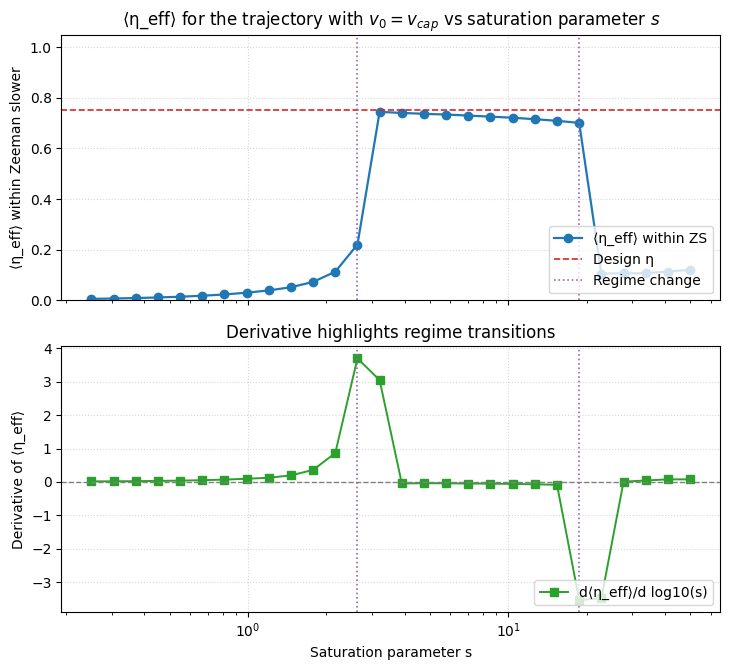

HTML(value="<div style='margin-top:0.3em'><b>Regime-change candidates</b>: s≈2.63 | s≈18.74</div>")

In [26]:
# Average η_eff along the Zeeman slower vs saturation parameter
# advanced_state = globals().get("_advanced_state")
# if not advanced_state:
#     raise RuntimeError("Run the advanced Zeeman slower widget before executing this analysis.")
# if "plot_phase_space" not in globals():
#     raise RuntimeError("Run the phase-space cell once so helper functions are defined and cached.")
# # Retrieve stored profile and parameters.
# species_props = dict(advanced_state["species_props"])
# gamma = float(species_props["gamma"])
# wavelength = float(species_props["wavelength"])
# mass = float(species_props["mass"]) * amu
# sat_in = species_props.get("sat_intensity", 60.0) or 60.0
# params = advanced_state["params"]
# g_eff_val = float(params["g_eff"])
# v_capture = float(params["v0"])
# v_final = float(params["vf"])
# if v_capture <= v_final:
#     raise RuntimeError("Stored profile has v0 <= vf. Re-run ZS Magnetic field design with valid parameters.")
# z_axis_core = np.asarray(advanced_state["z"])
# z_profile = np.asarray(advanced_state["z_extended"])
# B_profile_extended = np.asarray(advanced_state["B_extended"])
# if z_profile.size == 0 or B_profile_extended.size == 0:
#     raise RuntimeError("Extended magnetic profile is empty. Re-run ZS Magnetic field design with valid parameters.")
# kk = 2 * math.pi / wavelength
# diag = advanced_state["diagnostics"]
# delta_design = float(diag["delta_ideal"])
# eta_design = float(params["eta"])
# z_slower_start, z_slower_end = advanced_state["slower_bounds"]
# z_min, z_max = float(z_profile[0]), float(z_profile[-1])
# L_design = float(advanced_state["L"])
# flight_time = max(L_design / max(v_capture, 1.0), 1e-5)
# base_dt = flight_time / max(len(z_axis_core) - 1, 1)
# base_steps = max(len(z_profile), 2)
# min_speed = 1e-4  # m/s to avoid stalling

def _eta_sweep_integrate_capture(s_value, delta_laser):
    speed_scale = max(1.0, v_capture / max(abs(v_capture), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    traj_z = [z_min]
    traj_v = [v_capture]
    eta_samples = []
    for _ in range(max_steps):
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else v_capture
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # 
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        eta_samples.append(eta_point)
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    eta_samples = np.asarray(eta_samples)
    z_eta = np.asarray(traj_z[1 : eta_samples.size + 1])
    return z_eta, eta_samples

# Use a denser sampling of saturation parameters to reveal regime changes.
sweep_s_values = np.geomspace(0.25, 50.0, 28)
eta_means = []
for s_value in sweep_s_values:
    z_eta, eta_samples = _eta_sweep_integrate_capture(s_value, delta_design)
    if eta_samples.size == 0:
        eta_means.append(np.nan)
        continue
    # Compute mean eta_eff within the Zeeman slower region.
    mask = (z_eta >= z_slower_start) & (z_eta <= z_slower_end)  # Only samples within ZS
    eta_means.append(float(np.mean(eta_samples[mask])) if np.any(mask) else np.nan)
eta_means = np.asarray(eta_means)

log_s = np.log10(sweep_s_values)  # Logarithm of saturation parameters

# Numerical derivative of ⟨η_eff⟩ with respect to log10(s)
eta_derivative = np.full_like(eta_means, np.nan, dtype=float)  # Initialize with NaNs
finite_mask = np.isfinite(eta_means)  # Only compute derivative where eta_means is finite
if np.count_nonzero(finite_mask) >= 3:
    # Compute numerical derivative using finite differences
    eta_derivative[finite_mask] = np.gradient(
        eta_means[finite_mask],
        log_s[finite_mask],
    )

# Identify up to two saturation parameter values where the derivative magnitude is largest
transition_indices = []
finite_deriv_idx = np.where(np.isfinite(eta_derivative))[0]
# Rank by absolute derivative value
if finite_deriv_idx.size >= 2:  # Need at least two finite points to find transitions
    # Get indices sorted by descending absolute derivative
    ranked = finite_deriv_idx[np.argsort(np.abs(eta_derivative[finite_deriv_idx]))[::-1]]
    for idx in ranked:
        if idx not in transition_indices:
            transition_indices.append(idx)
        if len(transition_indices) == 2:
            break
transition_s = [sweep_s_values[i] for i in transition_indices]  # Corresponding s values

fig, (ax_eta, ax_deriv) = plt.subplots(2, 1, figsize=(7.4, 6.8), sharex=True)

ax_eta.plot(sweep_s_values, eta_means, marker="o", lw=1.6, label="⟨η_eff⟩ within ZS")
ax_eta.axhline(eta_design, color="tab:red", ls="--", lw=1.2, label="Design η")
for idx in transition_indices:
    s_val = sweep_s_values[idx]
    ax_eta.axvline(
        s_val,
        color="tab:purple",
        ls=":",
        lw=1.2,
        label="Regime change" if idx == transition_indices[0] else None,
    )
ax_eta.set_xscale("log")
ax_eta.set_ylabel("⟨η_eff⟩ within Zeeman slower")
ax_eta.set_ylim(0.0, 1.05)
ax_eta.grid(True, ls=":", alpha=0.5)
ax_eta.legend(loc="lower right")
ax_eta.set_title("⟨η_eff⟩ for the trajectory with $v_0 = v_{cap}$ vs saturation parameter $s$")

ax_deriv.plot(
    sweep_s_values,
    eta_derivative,
    color="tab:green",
    marker="s",
    lw=1.4,
    label="d⟨η_eff⟩/d log10(s)",
)
for idx in transition_indices:
    s_val = sweep_s_values[idx]
    ax_deriv.axvline(
        s_val,
        color="tab:purple",
        ls=":",
        lw=1.2,
    )
ax_deriv.axhline(0.0, color="gray", ls="--", lw=1.0)
ax_deriv.set_xscale("log")
ax_deriv.set_xlabel("Saturation parameter s")
ax_deriv.set_ylabel("Derivative of ⟨η_eff⟩")
ax_deriv.grid(True, ls=":", alpha=0.5)
ax_deriv.legend(loc="lower right")
ax_deriv.set_title("Derivative highlights regime transitions")
plt.tight_layout()
plt.show()
# # Summary table of results
# table_rows = [
#     (
#         f"s = {s_val:>6.2f} → ⟨η_eff⟩ = {eta_val:.3f}, "
#         f"d⟨η_eff⟩/dlog10(s) = {eta_derivative[i]:+.3f}"
#     )
#     if math.isfinite(eta_val) and math.isfinite(eta_derivative[i])
#     else (
#         f"s = {s_val:>6.2f} → ⟨η_eff⟩ = "
#         + (f"{eta_val:.3f}" if math.isfinite(eta_val) else "n/a")
#         + ", d⟨η_eff⟩/dlog10(s) = n/a"
#     )
#     for i, (s_val, eta_val) in enumerate(zip(sweep_s_values, eta_means))
# ]

if transition_s:
    transition_text = " | ".join([f"s≈{val:.2f}" for val in transition_s])
    transition_html = f"<b>Regime-change candidates</b>: {transition_text}"
else:
    transition_html = "<b>Regime-change candidates</b>: n/a"

# display(
#     w.HTML(
#         "<pre style='font-size:0.95em; margin-top:0.4em'>"
#         + "\n".join(table_rows)
#         + "</pre>"
#     )
# )
display(w.HTML(f"<div style='margin-top:0.3em'>{transition_html}</div>"))

In [27]:
from scipy.optimize import least_squares


# Angles for the 8 segments of the Halbach array
BETAS = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # n * pi/4 for n=0..7
EPS = 1e-12  # Small value to prevent division by zero


def _broadcast(*arrays):
    """Broadcast input arrays to a common shape with float dtype."""
    return np.broadcast_arrays(*[np.asarray(arr, dtype=float) for arr in arrays])


def translate_to_ring_frame(x, y, z, r0, z0, beta):
    """Translate lab-frame coordinates to the displaced magnet frame."""
    x, y, z, r0, z0 = _broadcast(x, y, z, r0, z0)
    xp = x - r0 * np.sin(beta)
    yp = y - r0 * np.cos(beta)
    zp = z - z0
    return xp, yp, zp


def rotate_xy_plane(x, y, angle):
    """Rotate coordinates in the XY plane by the provided angle."""
    x, y, angle = _broadcast(x, y, angle)
    c = np.cos(angle)
    s = np.sin(angle)
    xr = c * x - s * y
    yr = s * x + c * y
    return xr, yr


def rotate_about_v(xs, ys, zs, alpha, beta):
    """Rotate coordinates about the Halbach axis defined by beta."""
    xs, ys, zs, alpha = _broadcast(xs, ys, zs, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    xt = (cb**2 * (1 - ca) + ca) * xs + cb * sb * (1 - ca) * ys + sb * sa * zs
    yt = cb * sb * (1 - ca) * xs + (sb**2 * (1 - ca) + ca) * ys - cb * sa * zs
    zt = -sb * sa * xs + cb * sa * ys + ca * zs
    return xt, yt, zt


def inverse_rotate_about_v(bxt, byt, bzt, alpha, beta):
    """Undo the rotation about the Halbach axis for vector components."""
    bxt, byt, bzt, alpha = _broadcast(bxt, byt, bzt, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    bxs = (cb**2 * (1 - ca) + ca) * bxt + cb * sb * (1 - ca) * byt - sb * sa * bzt
    bys = cb * sb * (1 - ca) * bxt + (sb**2 * (1 - ca) + ca) * byt + cb * sa * bzt
    bzs = sb * sa * bxt - cb * sa * byt + ca * bzt
    return bxs, bys, bzs


def brond(x, y, z):
    """Calculate the magnetic field components from a rectangular magnet at position (x, y, z)."""
    x, y, z = _broadcast(x, y, z)   # Ensure inputs are numpy arrays with float dtype
    r = np.sqrt(x**2 + y**2 + z**2) + EPS  # Norm with EPS to avoid division by zero
    # Compute field components
    bxx = 0.5 * np.log(np.clip(r - z, EPS, None) / np.clip(r + z, EPS, None))
    byy = -np.arctan(np.divide(y * r, x * z + EPS))
    bzz = 0.5 * np.log(np.clip(r - x, EPS, None) / np.clip(r + x, EPS, None))
    return np.stack((bxx, byy, bzz), axis=-1)


def bmagnet(x, y, z, a, b, c, Br):
    """Calculate the magnetic field from a rectangular magnet
    with dimensions (2a, 2b, 2c) and remanent field Br at position (x, y, z)."""
    term = (
        brond(x - a, y - b, z - c) - brond(x + a, y - b, z - c)
        + brond(x + a, y + b, z - c) - brond(x - a, y + b, z - c)
        + brond(x - a, y + b, z + c) - brond(x - a, y - b, z + c)
        + brond(x + a, y - b, z + c) - brond(x + a, y + b, z + c)
    )
    return (Br / (4 * np.pi)) * term


def bdisrot(x, y, z, a, b, c, Br, r0, z0, alpha, beta):
    """Calculate the magnetic field from a rotated and displaced rectangular magnet."""
    x, y, z, r0, z0, alpha = _broadcast(x, y, z, r0, z0, alpha)
    xp, yp, zp = translate_to_ring_frame(x, y, z, r0, z0, beta)
    xs, ys = rotate_xy_plane(xp, yp, 2 * beta)
    xt, yt, zt = rotate_about_v(xs, ys, zp, alpha, beta)
    bvec = bmagnet(xt, yt, zt, a, b, c, Br)
    bxt = bvec[..., 0]
    byt = bvec[..., 1]
    bzt = bvec[..., 2]
    bxs, bys, bzs = inverse_rotate_about_v(bxt, byt, bzt, alpha, beta)
    bx, by = rotate_xy_plane(bxs, bys, -2 * beta)
    return np.stack((bx, by, bzs), axis=-1)


def bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha):
    """Calculate the magnetic field from an 8-segment Halbach array."""
    total = None
    for beta in BETAS:
        btmp = bdisrot(x, y, z, a, b, c, Br, R0, z0, alpha, beta)
        if total is None:
            total = np.zeros_like(btmp)
        total += btmp
    return total


def by_component(x, y, z, a, b, c, Br, R0, z0, alpha):
    '''Calculate the By component of the magnetic field from an 8-segment Halbach array.'''
    return bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha)[..., 1]

Best-fit: c = 126.2 mm, R0 = 26.2 mm, z0 = 133.6 mm, alpha = -4.73°
Inside slower: 252.3 mm | Outside entrance: 0.0 mm | Outside exit: 0.1 mm
Magnet span: z = 7.5 to 259.8 mm (center 133.6 mm)
Zero-field regions (extended profile): [-196.3, -0.4] mm (195.9 mm), [260.1, 312.7] mm (52.6 mm)
Halbach vs ideal RMS error: 113.46 G


{'result':      message: `ftol` termination condition is satisfied.
      success: True
       status: 2
          fun: [ 8.782e-06  8.851e-06 ...  2.042e-04  1.977e-04]
            x: [ 1.262e-01  2.619e-02  1.336e-01 -4.731e+00]
         cost: 0.07569053056656629
          jac: [[ 1.951e-04  3.942e-04 -1.594e-04 -1.256e-06]
                [ 1.969e-04  3.967e-04 -1.610e-04 -1.244e-06]
                ...
                [ 1.310e-02  2.516e-02  1.520e-02  6.851e-05]
                [ 1.258e-02  2.445e-02  1.462e-02  6.710e-05]]
         grad: [-1.329e-03 -8.544e-05 -1.368e-03 -3.780e-07]
   optimality: 0.0003643611472478081
  active_mask: [0 0 0 0]
         nfev: 25
         njev: 25,
 'z_fit': array([-0.1962838 , -0.1958505 , -0.1954172 , ...,  0.31185441,
         0.31228531,  0.3127162 ]),
 'ideal_profile_T': array([0., 0., 0., ..., 0., 0., 0.]),
 'halbach_profile_T': array([8.78162537e-06, 8.85092330e-06, 8.92091409e-06, ...,
        2.10834019e-04, 2.04156654e-04, 1.97731274e-04]

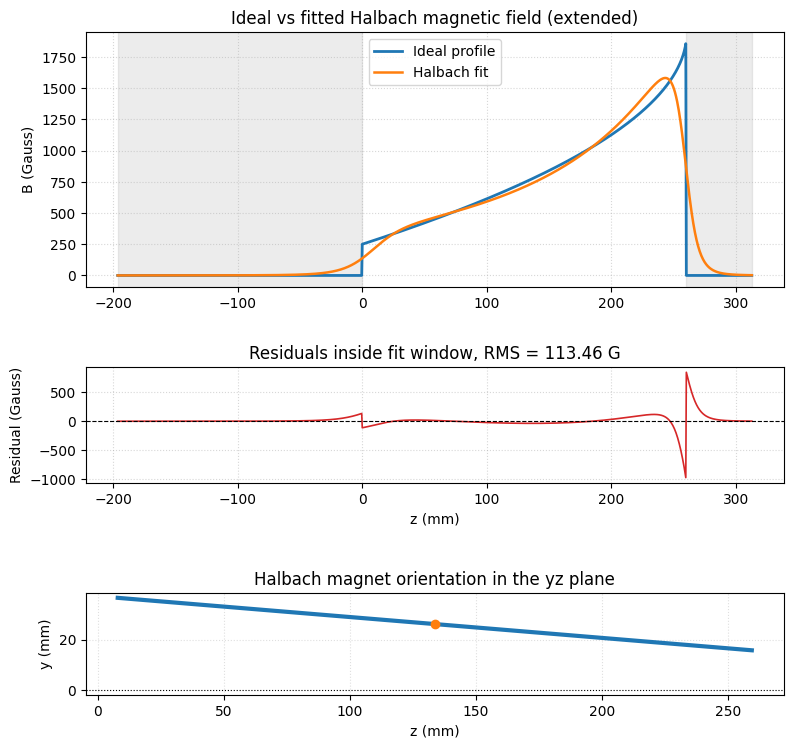

In [28]:
# Default Halbach geometry parameters in millimeters and Gauss
HALBACH_DEFAULTS = {
    "a_mm": 6.0 / 2.0,
    "b_mm": 6.0 / 2.0,
    "c_mm": 128.0 / 2.0,
    "Br": 1.08e4,  # Remanent field in Gauss
    "R0_mm": 54.0 / 2.0,
    "z0_mm": 0.0,
    "alpha_deg": -0.97,
}

# Helper functions for Halbach field calculations and fitting
def _defaults_mks():
    """Return Halbach geometry defaults converted to SI units."""
    return {
        "a": HALBACH_DEFAULTS["a_mm"] * 1e-3,
        "b": HALBACH_DEFAULTS["b_mm"] * 1e-3,
        "c": HALBACH_DEFAULTS["c_mm"] * 1e-3,
        "R0": HALBACH_DEFAULTS["R0_mm"] * 1e-3,
        "z0": HALBACH_DEFAULTS["z0_mm"] * 1e-3,
    }


# Compute Halbach field along the z-axis
def halbach_axis_field(z_m, c_m, R0_m, z0_m, alpha_deg, *, a_m=None, b_m=None, Br=None):
    """Return the By component (Tesla) of the Halbach stack along the z-axis."""
    cfg = _defaults_mks()  # Get default geometry in meters
    # Use provided or default values
    a_m = cfg["a"] if a_m is None else a_m
    b_m = cfg["b"] if b_m is None else b_m
    Br = HALBACH_DEFAULTS["Br"] if Br is None else Br
    alpha_rad = np.deg2rad(alpha_deg)
    # Compute By field in Gauss
    by_gauss = by_component(
        0.0,
        0.0,
        z_m,
        a_m,
        b_m,
        c_m,
        Br,
        R0_m,
        z0_m,
        alpha_rad,
    )
    return by_gauss * 1e-4  # Convert Gauss → Tesla


# Load the ideal Zeeman slower profile from the cached advanced state
def _load_ideal_profile(*, include_extended=True):
    state = globals().get("_advanced_state")
    if not state:
        raise RuntimeError(
            "Run the advanced Zeeman slower design cell first so the ideal magnetic profile is cached."
        )
    z_key = "z_extended" if include_extended and "z_extended" in state else "z"
    B_key = "B_extended" if include_extended and "B_extended" in state else "B"
    z_profile = np.asarray(state[z_key], dtype=float)
    B_profile = np.asarray(state[B_key], dtype=float)
    if z_profile.size == 0 or B_profile.size == 0:
        raise RuntimeError("Cached ideal profile is empty; rerun the design cell with valid parameters.")
    return z_profile, B_profile, state


# Extract contiguous segments from a boolean mask
def _segments_from_mask(z_vals, mask):
    """Return start/end index pairs for contiguous True regions in mask."""
    segments = []
    if not np.any(mask):
        return segments
    start_idx = None
    for idx, flag in enumerate(mask):
        if flag and start_idx is None:
            start_idx = idx
        elif not flag and start_idx is not None:
            segments.append((start_idx, idx - 1))
            start_idx = None
    if start_idx is not None:
        segments.append((start_idx, np.where(mask)[0][-1]))
    return [(z_vals[i0], z_vals[i1]) for i0, i1 in segments]


def fit_halbach_to_ideal(fit_window_m=None, include_extended=True, zero_tol_T=1e-8):
    """Fit the Halbach By field to the stored ideal Zeeman-slower profile."""
    z_profile, B_profile, state = _load_ideal_profile(include_extended=include_extended)
    if fit_window_m is None:
        mask = np.ones_like(z_profile, dtype=bool)
    else:
        z_min, z_max = fit_window_m
        mask = (z_profile >= z_min) & (z_profile <= z_max)
    z_fit = z_profile[mask]     # Fit region
    B_target = B_profile[mask]  # Target field in fit region
    if z_fit.size < 4:
        raise RuntimeError("Fit window is too small; ensure the mask keeps at least 4 samples.")

    # Initial guess and bounds for [c, R0, z0, alpha_deg]
    geom = _defaults_mks()
    par0 = np.array([
        geom["c"],
        geom["R0"],
        geom["z0"],
        HALBACH_DEFAULTS["alpha_deg"],
    ])
    # Bounds for parameters
    lower_bounds = np.array([2e-3, 5e-3, -0.15, -15.0])
    upper_bounds = np.array([0.25, 0.06, 0.40, 15.0])

    def residuals(p):
        c_m, R0_m, z0_m, alpha_deg = p
        halbach_T = halbach_axis_field(
            z_fit,
            c_m,
            R0_m,
            z0_m,
            alpha_deg,
            a_m=geom["a"],
            b_m=geom["b"],
            Br=HALBACH_DEFAULTS["Br"],
        )
        return halbach_T - B_target

    result = least_squares(residuals, par0, bounds=(lower_bounds, upper_bounds))
    fitted_profile_T = halbach_axis_field(
        z_fit,
        result.x[0],
        result.x[1],
        result.x[2],
        result.x[3],
        a_m=geom["a"],
        b_m=geom["b"],
        Br=HALBACH_DEFAULTS["Br"],
    )
    error_T = fitted_profile_T - B_target
    # Compute RMS error in Gauss
    # RMS is Root Mean Square of the residuals
    rms_error_G = np.sqrt(np.mean(error_T**2)) * 1e4

    halbach_full_T = halbach_axis_field(
        z_profile,
        result.x[0],
        result.x[1],
        result.x[2],
        result.x[3],
        a_m=geom["a"],
        b_m=geom["b"],
        Br=HALBACH_DEFAULTS["Br"],
    )
    # Identify zero-field segments in the ideal profile (for shading area plot)
    zero_mask = np.isclose(B_profile, 0.0, atol=zero_tol_T)
    zero_segments = _segments_from_mask(z_profile, zero_mask)

    fig = plt.figure(figsize=(9, 9))
    # Create a gridspec layout for the three subplots
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.0, 1.4], hspace=0.45)
    ax_main = fig.add_subplot(gs[0])
    ax_err = fig.add_subplot(gs[1], sharex=ax_main)
    ax_orient = fig.add_subplot(gs[2])

    # Main plot: Ideal vs fitted Halbach profile
    for start_m, end_m in zero_segments:
        ax_main.axvspan(start_m * 1e3, end_m * 1e3, color="gray", alpha=0.15)
    ax_main.plot(z_profile * 1e3, B_profile * 1e4, label="Ideal profile", lw=2.0)
    ax_main.plot(z_profile * 1e3, halbach_full_T * 1e4, label="Halbach fit", lw=1.8)
    ax_main.set_ylabel("B (Gauss)")
    ax_main.set_title("Ideal vs fitted Halbach magnetic field (extended)")
    ax_main.grid(True, ls=":", alpha=0.5)
    ax_main.legend()

    # Residuals plot: Fit window errors
    ax_err.plot(z_fit * 1e3, error_T * 1e4, color="tab:red", lw=1.2)
    ax_err.axhline(0.0, color="k", lw=0.8, ls="--")
    ax_err.set_xlabel("z (mm)")
    ax_err.set_ylabel("Residual (Gauss)")
    ax_err.grid(True, ls=":", alpha=0.5)
    ax_err.set_title(f"Residuals inside fit window, RMS = {rms_error_G:.2f} G")

    # Orientation plot: Halbach axis in yz plane
    c_m, R0_m, z0_m, alpha_deg = result.x
    alpha_rad = np.deg2rad(alpha_deg)
    span = np.array([-c_m, c_m])
    z_line = (z0_m + span * np.cos(alpha_rad)) * 1e3
    y_line = (R0_m + span * np.sin(alpha_rad)) * 1e3
    ax_orient.plot(z_line, y_line, color="tab:blue", lw=3)
    ax_orient.scatter([z0_m * 1e3], [R0_m * 1e3], color="tab:orange", zorder=3)
    ax_orient.axhline(0.0, color="k", lw=0.8, ls=":")
    ax_orient.set_xlabel("z (mm)")
    ax_orient.set_ylabel("y (mm)")
    ax_orient.set_title("Halbach magnet orientation in the yz plane")
    ax_orient.set_aspect("equal", adjustable="box")
    ax_orient.grid(True, ls=":", alpha=0.4)

    # Summary of fitted parameters and lengths
    fitted_mm = {
        "c_mm": c_m * 1e3,
        "R0_mm": R0_m * 1e3,
        "z0_mm": z0_m * 1e3,
        "alpha_deg": alpha_deg,
    }
    summary = (
        f"Best-fit: c = {fitted_mm['c_mm']:.1f} mm, R0 = {fitted_mm['R0_mm']:.1f} mm, "
        f"z0 = {fitted_mm['z0_mm']:.1f} mm, alpha = {fitted_mm['alpha_deg']:.2f}°"
    )

    # Compute lengths inside/outside the slower region
    slower_min, slower_max = state["slower_bounds"]
    mag_min = z0_m - c_m
    mag_max = z0_m + c_m
    overlap = max(0.0, min(mag_max, slower_max) - max(mag_min, slower_min))
    outside_before = max(0.0, slower_min - mag_min)
    outside_after = max(0.0, mag_max - slower_max)
    total_length_mm = 2 * c_m * 1e3
    overlap_mm = overlap * 1e3
    outside_before_mm = outside_before * 1e3
    outside_after_mm = outside_after * 1e3
    magnet_span_mm = (mag_min * 1e3, mag_max * 1e3)
    zero_segments_mm = [
        (start * 1e3, end * 1e3, (end - start) * 1e3)
        for start, end in zero_segments
    ]

    print(summary)
    print(
        f"Inside slower: {overlap_mm:.1f} mm | Outside entrance: {outside_before_mm:.1f} mm | "
        f"Outside exit: {outside_after_mm:.1f} mm"
    )
    print(
        f"Magnet span: z = {magnet_span_mm[0]:.1f} to {magnet_span_mm[1]:.1f} mm (center {fitted_mm['z0_mm']:.1f} mm)"
    )
    if zero_segments_mm:
        zero_text = ", ".join(
            f"[{start:.1f}, {end:.1f}] mm ({length:.1f} mm)"
            for start, end, length in zero_segments_mm
        )
    else:
        zero_text = "None"
    print(f"Zero-field regions (extended profile): {zero_text}")
    print(f"Halbach vs ideal RMS error: {rms_error_G:.2f} G")
    return {
        "result": result,
        "z_fit": z_fit,
        "ideal_profile_T": B_target,
        "halbach_profile_T": fitted_profile_T,
        "residuals_T": error_T,
        "summary": summary,
        "rms_error_G": rms_error_G,
        "lengths_mm": {
            "total": total_length_mm,
            "inside": overlap_mm,
            "outside_before": outside_before_mm,
            "outside_after": outside_after_mm,
        },
        "magnet_span_mm": magnet_span_mm,
        "zero_segments_mm": zero_segments_mm,
    }


fit_halbach_to_ideal(include_extended=True)

Sectioned fit RMS error: 349.75 G | inside slower 223.2 mm | outside entrance 0.0 mm | outside exit 0.0 mm
Section 1 magnet 1: length 110.0 mm | center 73.8 mm | alpha -3.59° | amp 0.78
Section 2 magnet 1: length 110.0 mm | center 187.0 mm | alpha -6.54° | amp 1.72


Output()

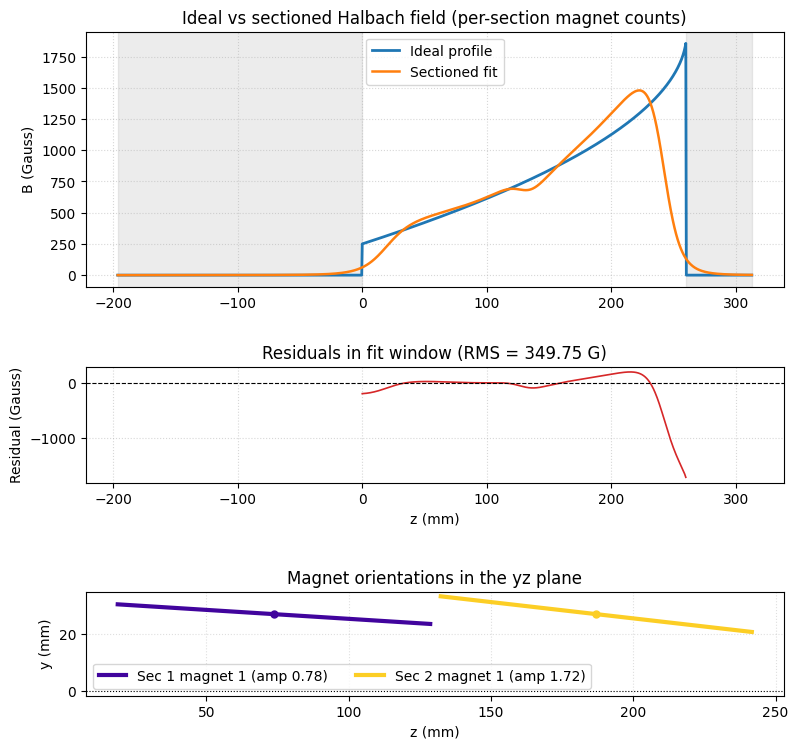

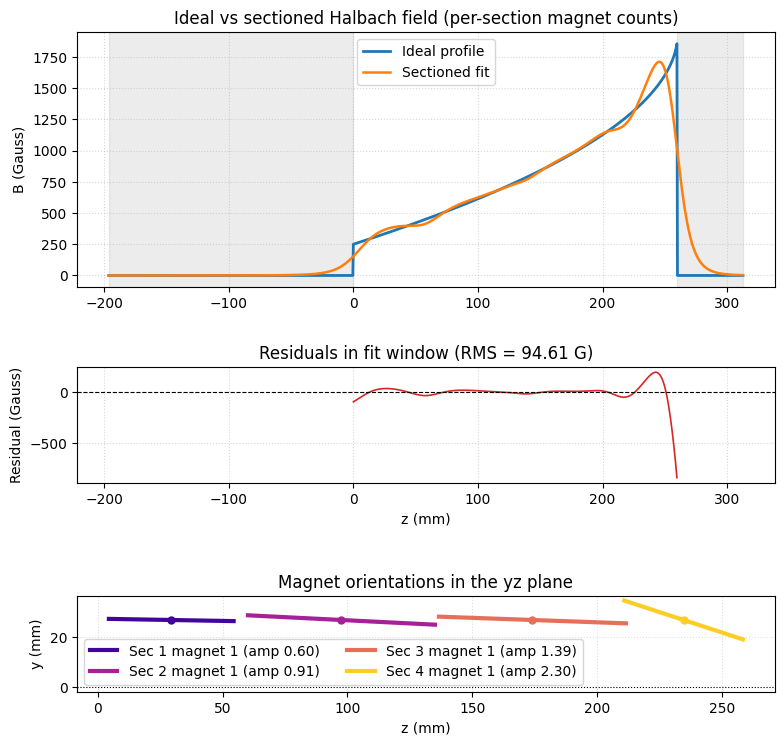

In [40]:
# Fixed-length section optimizer with per-section magnet counts

def _compute_section_spans(section_bounds, section_lengths_mm, auto_scale):
    """Return section spans (m) and edges that honor the slower boundaries."""
    slower_min, slower_max = section_bounds
    slower_span_m = slower_max - slower_min
    spans_m = np.asarray(section_lengths_mm, dtype=float) * 1e-3
    if spans_m.size == 0:
        raise ValueError("Provide at least one section length in millimeters")
    if np.any(spans_m <= 0):
        raise ValueError("Section lengths must be positive")
    requested_span_m = float(np.sum(spans_m))
    scale_factor = 1.0
    if auto_scale and not np.isclose(requested_span_m, slower_span_m, rtol=1e-3, atol=1e-6):
        scale_factor = slower_span_m / requested_span_m
        spans_m = spans_m * scale_factor
        requested_span_m = float(np.sum(spans_m))
    elif requested_span_m > slower_span_m + 1e-9:
        raise ValueError(
            f"Requested section lengths ({requested_span_m*1e3:.1f} mm) exceed the slower span "
            f"({slower_span_m*1e3:.1f} mm). Reduce the lengths or enable auto_scale."
        )
    edges = np.concatenate(([slower_min], slower_min + np.cumsum(spans_m)))
    return spans_m, edges, scale_factor, requested_span_m


def _build_section_slots(
    section_bounds,
    section_edges,
    half_lengths_m,
    magnet_counts,
    extension_fraction,
):
    """Produce slot dictionaries per magnet, keeping magnets in the same section stacked."""
    slower_min, slower_max = section_bounds
    slots = []
    for sec_idx in range(len(half_lengths_m)):
        span = section_edges[sec_idx + 1] - section_edges[sec_idx]
        half_len = half_lengths_m[sec_idx]
        if half_len <= 0:
            raise ValueError("Section spans must be positive")
        extension = span * extension_fraction
        slot_start = max(slower_min, section_edges[sec_idx] - extension)
        slot_end = min(slower_max, section_edges[sec_idx + 1] + extension)
        usable = slot_end - slot_start
        if usable <= 2 * half_len:
            raise ValueError(
                f"Section {sec_idx + 1} span plus extension ({usable*1e3:.1f} mm) is too short for the magnet length "
                f"{2*half_len*1e3:.1f} mm. Increase the extension fraction or reduce the length."
            )
        center_min = slot_start + half_len
        center_max = slot_end - half_len
        count = int(magnet_counts[sec_idx])
        if count < 1:
            raise ValueError("Each section must have at least one magnet")
        for slot_idx in range(count):
            slots.append(
                {
                    "section": sec_idx + 1,
                    "slot": slot_idx + 1,
                    "center_min": center_min,
                    "center_max": center_max,
                    "slot_bounds": (slot_start, slot_end),
                    "half_length": half_len,
                }
            )
    return slots


def _initial_parameter_vectors(slots, max_angle_deg, amp_bounds):
    """Create deterministic seed vectors for the nonlinear solver."""
    amp_min, amp_max = amp_bounds
    configs = [
        {"center_shift": 0.0, "angle_bias": 0.0, "amp_scale": 1.0},
        {"center_shift": -0.4, "angle_bias": -0.35, "amp_scale": min(amp_max, 1.3)},
        {"center_shift": 0.4, "angle_bias": 0.35, "amp_scale": max(amp_min, 0.8)},
    ]
    vectors = []
    for cfg in configs:
        guess = []
        for slot in slots:
            slack = slot["center_max"] - slot["center_min"]
            mid = 0.5 * (slot["center_min"] + slot["center_max"])
            center = np.clip(mid + cfg["center_shift"] * 0.5 * slack, slot["center_min"], slot["center_max"])
            angle = np.clip(cfg["angle_bias"] * max_angle_deg, -max_angle_deg, max_angle_deg)
            amp = np.clip(cfg["amp_scale"], amp_min, amp_max)
            guess.extend([center, angle, amp])
        vectors.append(np.array(guess, dtype=float))
    return vectors


def fit_sectioned_fixed_magnets(
    n_sections=2,
    magnets_per_section=1,
    magnet_length_mm=110.0,
    magnet_lengths_mm=None,
    per_section_magnet_counts=None,
    include_extended=True,
    zero_tol_T=1e-8,
    max_angle_deg=20.0,
    fit_window_m=None,
    section_extension_fraction=0.2,
    amp_bounds=(0.2, 2.8),
    auto_scale_sections=False,
    plot=True,
):
    """Fit Halbach stacks where each section length matches every magnet in that section."""
    if n_sections < 1:
        raise ValueError("n_sections must be >= 1")

    if magnet_lengths_mm is None:
        section_lengths_mm = np.full(n_sections, magnet_length_mm, dtype=float)
    else:
        section_lengths_mm = np.asarray(magnet_lengths_mm, dtype=float)
    if section_lengths_mm.size != n_sections:
        raise ValueError("Provide exactly one length per section")
    if np.any(section_lengths_mm <= 0):
        raise ValueError("Section lengths must be positive")

    if per_section_magnet_counts is None:
        magnet_counts = np.full(n_sections, int(magnets_per_section), dtype=int)
    else:
        magnet_counts = np.asarray(per_section_magnet_counts, dtype=int)
    if magnet_counts.size != n_sections:
        raise ValueError("Provide one magnet count per section")
    if np.any(magnet_counts < 1):
        raise ValueError("Each section must contain at least one magnet")

    z_profile, B_profile, state = _load_ideal_profile(include_extended=include_extended)
    slower_bounds = state["slower_bounds"]
    if fit_window_m is None:
        fit_window_m = slower_bounds

    spans_m, section_edges, scale_factor, requested_span_m = _compute_section_spans(
        slower_bounds, section_lengths_mm, auto_scale_sections
    )
    half_lengths_m = 0.5 * spans_m
    slots = _build_section_slots(
        slower_bounds,
        section_edges,
        half_lengths_m,
        magnet_counts,
        section_extension_fraction,
    )

    amp_min, amp_max = amp_bounds
    if amp_min < 0 or amp_max <= amp_min:
        raise ValueError("amp_bounds must satisfy 0 <= min < max")

    lower_bounds = []
    upper_bounds = []
    for slot in slots:
        lower_bounds.extend([slot["center_min"], -max_angle_deg, amp_min])
        upper_bounds.extend([slot["center_max"], max_angle_deg, amp_max])
    lower_bounds = np.array(lower_bounds, dtype=float)
    upper_bounds = np.array(upper_bounds, dtype=float)

    geom = _defaults_mks()

    def summed_field(params, axis):
        centers = params[0::3]
        angles = params[1::3]
        amps = params[2::3]
        total = np.zeros_like(axis)
        for center, alpha_deg, amp_scale, slot in zip(centers, angles, amps, slots):
            total += amp_scale * halbach_axis_field(
                axis,
                slot["half_length"],
                geom["R0"],
                center,
                alpha_deg,
                a_m=geom["a"],
                b_m=geom["b"],
                Br=HALBACH_DEFAULTS["Br"],
            )
        return total

    z_min_fit, z_max_fit = fit_window_m
    fit_mask = (z_profile >= z_min_fit) & (z_profile <= z_max_fit)
    if np.count_nonzero(fit_mask) < 4:
        raise RuntimeError("Fit window keeps fewer than 4 samples; widen the range")
    z_fit = z_profile[fit_mask]
    B_target = B_profile[fit_mask]

    seed_vectors = _initial_parameter_vectors(slots, max_angle_deg, amp_bounds)
    best_result = None
    best_rms = np.inf
    for seed in seed_vectors:
        result = least_squares(
            lambda p: summed_field(p, z_fit) - B_target,
            seed,
            bounds=(lower_bounds, upper_bounds),
        )
        residual = summed_field(result.x, z_fit) - B_target
        rms = np.sqrt(np.mean(residual**2)) * 1e4
        if rms < best_rms:
            best_rms = rms
            best_result = result

    if best_result is None:
        raise RuntimeError("Least-squares solver failed for all seeds")

    result = best_result
    fitted_profile_T = summed_field(result.x, z_fit)
    full_profile_T = summed_field(result.x, z_profile)
    error_fit_T = fitted_profile_T - B_target
    rms_error_G = best_rms

    zero_mask = np.isclose(B_profile, 0.0, atol=zero_tol_T)
    zero_segments = _segments_from_mask(z_profile, zero_mask)

    sections = []
    centers = result.x[0::3]
    angles = result.x[1::3]
    amps = result.x[2::3]
    for slot, center, alpha, amp_scale in zip(slots, centers, angles, amps):
        sections.append(
            {
                "section": slot["section"],
                "slot": slot["slot"],
                "length_mm": 2 * slot["half_length"] * 1e3,
                "center_mm": center * 1e3,
                "alpha_deg": alpha,
                "amp_scale": amp_scale,
                "slot_start_mm": slot["slot_bounds"][0] * 1e3,
                "slot_end_mm": slot["slot_bounds"][1] * 1e3,
            }
        )

    if plot:
        fig = plt.figure(figsize=(9, 9))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.0, 1.4], hspace=0.45)
        ax_main = fig.add_subplot(gs[0])
        ax_err = fig.add_subplot(gs[1], sharex=ax_main)
        ax_orient = fig.add_subplot(gs[2])

        for start_m, end_m in zero_segments:
            ax_main.axvspan(start_m * 1e3, end_m * 1e3, color="gray", alpha=0.15)
        ax_main.plot(z_profile * 1e3, B_profile * 1e4, label="Ideal profile", lw=2.0)
        ax_main.plot(z_profile * 1e3, full_profile_T * 1e4, label="Sectioned fit", lw=1.8)
        ax_main.set_ylabel("B (Gauss)")
        ax_main.set_title(
            "Ideal vs sectioned Halbach field (per-section magnet counts)"
        )
        ax_main.grid(True, ls=":", alpha=0.5)
        ax_main.legend()

        ax_err.plot(z_fit * 1e3, error_fit_T * 1e4, color="tab:red", lw=1.2)
        ax_err.axhline(0.0, color="k", lw=0.8, ls="--")
        ax_err.set_xlabel("z (mm)")
        ax_err.set_ylabel("Residual (Gauss)")
        ax_err.grid(True, ls=":", alpha=0.5)
        ax_err.set_title(f"Residuals in fit window (RMS = {rms_error_G:.2f} G)")

        colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(sections)))
        for color, entry, slot in zip(colors, sections, slots):
            center_m = entry["center_mm"] * 1e-3
            alpha_rad = np.deg2rad(entry["alpha_deg"])
            span = np.array([-slot["half_length"], slot["half_length"]])
            z_line = (center_m + span * np.cos(alpha_rad)) * 1e3
            y_line = (geom["R0"] + span * np.sin(alpha_rad)) * 1e3
            ax_orient.plot(
                z_line,
                y_line,
                lw=3,
                color=color,
                label=f"Sec {entry['section']} magnet {entry['slot']} (amp {entry['amp_scale']:.2f})"
            )
            ax_orient.scatter([center_m * 1e3], [geom["R0"] * 1e3], color=color, s=25)
        ax_orient.axhline(0.0, color="k", lw=0.8, ls=":")
        ax_orient.set_xlabel("z (mm)")
        ax_orient.set_ylabel("y (mm)")
        ax_orient.set_title("Magnet orientations in the yz plane")
        ax_orient.set_aspect("equal", adjustable="box")
        ax_orient.grid(True, ls=":", alpha=0.4)
        ax_orient.legend(ncol=2)

    slot_half_lengths = np.array([slot["half_length"] for slot in slots])
    mag_min = np.min(centers - slot_half_lengths)
    mag_max = np.max(centers + slot_half_lengths)
    slower_min, slower_max = slower_bounds
    overlap = max(0.0, min(mag_max, slower_max) - max(mag_min, slower_min))
    outside_before = max(0.0, slower_min - mag_min)
    outside_after = max(0.0, mag_max - slower_max)
    zero_segments_mm = [
        (start * 1e3, end * 1e3, (end - start) * 1e3)
        for start, end in zero_segments
    ]

    print(
        f"Sectioned fit RMS error: {rms_error_G:.2f} G | inside slower {overlap*1e3:.1f} mm | "
        f"outside entrance {outside_before*1e3:.1f} mm | outside exit {outside_after*1e3:.1f} mm"
    )
    for entry in sections:
        print(
            f"Section {entry['section']} magnet {entry['slot']}: length {entry['length_mm']:.1f} mm | "
            f"center {entry['center_mm']:.1f} mm | alpha {entry['alpha_deg']:.2f}° | amp {entry['amp_scale']:.2f}"
        )
    if not np.isclose(scale_factor, 1.0):
        print(
            f"Section lengths were scaled by {scale_factor:.3f} so that the total span matches the slower length "
            f"({requested_span_m*1e3:.1f} mm request)."
        )

    return {
        "result": result,
        "z_profile": z_profile,
        "z_fit": z_fit,
        "ideal_profile_full_T": B_profile,
        "halbach_full_T": full_profile_T,
        "residuals_T": error_fit_T,
        "rms_error_G": rms_error_G,
        "sections": sections,
        "section_edges_mm": (section_edges * 1e3).tolist(),
        "section_lengths_mm": (spans_m * 1e3).tolist(),
        "magnet_counts": magnet_counts.tolist(),
        "fit_window_m": fit_window_m,
        "amp_bounds": list(amp_bounds),
    }


sectioned_fixed_fit = fit_sectioned_fixed_magnets(
    n_sections=2,
    magnets_per_section=1,
    magnet_lengths_mm=[110.0, 110.0],
    per_section_magnet_counts=[1, 1],
    include_extended=True,
)

# Widgets to control sectioned fixed-magnet optimization
section_count_slider = w.IntSlider(
    description="Sections",
    min=1,
    max=6,
    value=2,
    step=1,
    continuous_update=False,
)

def _build_length_inputs(count):
    inputs = []
    for idx in range(count):
        ft = w.FloatText(
            description=f"Sec {idx + 1} L (mm)",
            value=110.0,
            step=1.0,
            min=1.0,
            layout=w.Layout(width="220px"),
        )
        inputs.append(ft)
    return inputs

def _build_count_inputs(count):
    inputs = []
    for idx in range(count):
        it = w.IntText(
            description=f"Sec {idx + 1} mags",
            value=1,
            min=1,
            layout=w.Layout(width="160px"),
        )
        inputs.append(it)
    return inputs

length_inputs_box = w.VBox()
count_inputs_box = w.HBox()
length_hint = w.HTML(
    "<em>Each magnet in a section shares the section length; additional magnets stack radially without overlapping along z.</em>"
)

def _refresh_section_inputs(change=None):
    count = section_count_slider.value
    length_inputs_box.children = tuple(_build_length_inputs(count))
    count_inputs_box.children = tuple(_build_count_inputs(count))

_refresh_section_inputs()
section_count_slider.observe(_refresh_section_inputs, names="value")

run_sectioned_button = w.Button(description="Run sectioned fit", button_style="success")
sectioned_fit_output = w.Output()

def _run_sectioned_fit(_):
    lengths = [child.value for child in length_inputs_box.children]
    counts = [child.value for child in count_inputs_box.children]
    sectioned_fit_output.clear_output()
    with sectioned_fit_output:
        try:
            result = fit_sectioned_fixed_magnets(
                n_sections=section_count_slider.value,
                magnet_lengths_mm=lengths,
                per_section_magnet_counts=counts,
                include_extended=True,
            )
            globals()["sectioned_widget_fit"] = result
        except Exception as exc:
            print("Error running sectioned fit:", exc)

run_sectioned_button.on_click(_run_sectioned_fit)

ui_sectioned = w.VBox(
    [
        section_count_slider,
        length_hint,
        length_inputs_box,
        count_inputs_box,
        run_sectioned_button,
    ]
)

display(ui_sectioned, sectioned_fit_output)

In [37]:
# Quick sweep to compare section counts
rms_table = []
base_lengths_mm = [110.0]
slower_min, slower_max = globals()["_advanced_state"]["slower_bounds"]
slower_span_mm = (slower_max - slower_min) * 1e3

for sections in range(1, 6):
    section_lengths = base_lengths_mm * sections
    fit = fit_sectioned_fixed_magnets(
        n_sections=sections,
        magnets_per_section=1,
        magnet_lengths_mm=section_lengths,
        include_extended=True,
        auto_scale_sections=True,
        plot=False,
    )
    rms_table.append((sections, fit["rms_error_G"], fit["section_spans_mm"]))

for sections, rms, spans in rms_table:
    span_str = ", ".join(f"{s:.1f} mm" for s in spans)
    print(f"Sections: {sections}, RMS error: {rms:.2f} G, spans: [{span_str}] (sum {sum(spans):.1f} mm)")

Section spans scaled by 2.361 to fill the slower length (259.7 mm).
Sectioned fit RMS error: 115.77 G | inside slower 254.5 mm | outside entrance 0.0 mm | outside exit 0.0 mm
Section 1 slot 1: length 254.5 mm | center 132.5 mm | alpha -5.00° | amp 1.05
User-requested total 110.0 mm was scaled to 259.7 mm to match the slower span.
Section spans scaled by 1.181 to fill the slower length (259.7 mm).
Sectioned fit RMS error: 124.99 G | inside slower 257.1 mm | outside entrance 0.0 mm | outside exit 0.0 mm
Section 1 slot 1: length 127.3 mm | center 66.2 mm | alpha -4.51° | amp 0.71
Section 2 slot 1: length 127.3 mm | center 196.1 mm | alpha -6.65° | amp 1.67
User-requested total 220.0 mm was scaled to 259.7 mm to match the slower span.
Section spans scaled by 0.787 to fill the slower length (259.7 mm).
Sectioned fit RMS error: 114.92 G | inside slower 258.0 mm | outside entrance 0.0 mm | outside exit 0.0 mm
Section 1 slot 1: length 84.8 mm | center 44.2 mm | alpha -3.57° | amp 0.61
Section 